In [67]:
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/capstone22/WildFIrePrediction/PwC-LSTM-Capstone-Project/src/')
from roc import plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import matplotlib.pyplot as plt

Data Loading

In [68]:
'''
df_train = pd.read_csv('/home/capstone22/WildFIrePrediction/isaac_data/Isaac_data_original/isaac_train.csv')
df_valid = pd.read_csv('/home/capstone22/WildFIrePrediction/isaac_data/Isaac_data_original/isaac_valid.csv')
df_test = pd.read_csv('/home/capstone22/WildFIrePrediction/isaac_data/Isaac_data_original/isaac_test.csv')
'''

"\ndf_train = pd.read_csv('/home/capstone22/WildFIrePrediction/isaac_data/Isaac_data_original/isaac_train.csv')\ndf_valid = pd.read_csv('/home/capstone22/WildFIrePrediction/isaac_data/Isaac_data_original/isaac_valid.csv')\ndf_test = pd.read_csv('/home/capstone22/WildFIrePrediction/isaac_data/Isaac_data_original/isaac_test.csv')\n"

In [69]:
coords = pd.read_csv('/home/capstone22/WildFIrePrediction/isaac_data/LatLon.csv')

In [70]:
df_train = pd.DataFrame()

for i in range(2003,2011):
    PATH = '/home/capstone22/WildFIrePrediction/isaac_data/Isaac_data_original/'
    CD_PATH = PATH + 'CD_' + str(i) + '_' + str(i) + '.csv'
    TD_PATH = PATH + 'TD_' + str(i) + '_' + str(i) + '.csv'
    
    df_temp = pd.read_csv(CD_PATH)
    df_temp = df_temp.loc[coords['pixel_id']]

    gt_temp = pd.read_csv(TD_PATH)
    gt_temp = gt_temp.loc[coords['pixel_id']]

    df_temp['value'] = gt_temp['value']

    df_train = df_train.append(df_temp)

df_train.info

<bound method DataFrame.info of          pixel_id  pixel_id.1  Road_Dist  Elec_Dist  Cultivated_Prop   Elev  \
134588     134588      134588     0.0000   8.602325         0.000000   72.0   
134589     134589      134589  1000.0000   8.062258         0.000000   78.0   
134590     134590      134590  2000.0000   7.615773         0.000000   50.0   
134591     134591      134591  3000.0000   7.280110         0.000000  121.0   
134592     134592      134592  4000.0000   7.071068         0.000000  182.0   
...           ...         ...        ...        ...              ...    ...   
1126081   1126081     1126081  5000.0000   4.472136         0.014888    2.0   
1126082   1126082     1126082  4242.6406   4.123106         0.009844    3.0   
1126083   1126083     1126083  3605.5513   4.000000         0.005226   13.0   
1126084   1126084     1126084  3162.2776   4.000000         0.003966   17.0   
1126085   1126085     1126085  2828.4272   4.000000         0.000276   21.0   

           time_Nor

In [71]:
dataframes = []
groundTruth = []

for i in range(2011, 2018):
    PATH = '/home/capstone22/WildFIrePrediction/isaac_data/Isaac_data_original/'
    CD_PATH = PATH + 'CD_' + str(i) + '_' + str(i) + '.csv'
    TD_PATH = PATH + 'TD_' + str(i) + '_' + str(i) + '.csv'

    df = pd.read_csv(CD_PATH)
    gt = pd.read_csv(TD_PATH)

    df = df.loc[coords['pixel_id']]
    gt = gt.loc[coords['pixel_id']]

    dataframes.append(df)
    groundTruth.append(gt['value'])

Feature Selection

In [72]:
# selected_features = ['Road_Dist',
#                      'Elec_Dist',
#                      'Cultivated_Prop',
#                      'aet__maximum_Normal',
#                      'aet__mean_Normal',
#                      'aet__minimum_Normal',
#                      'cwd__maximum_Normal',
#                      'cwd__mean_Normal',
#                      'cwd__minimum_Normal',
#                      'pck__maximum_Normal',
#                      'pck__mean_Normal',
#                      'pck__minimum_Normal',
#                      'aet__mean_ThreeYear_Dev',
#                      'cwd__mean_ThreeYear_Dev',
#                      'Mean_Housing_Dens_25km',
#                      'FFWI'     ]

selected_features = ['Road_Dist',
                    'Elec_Dist',
                    'aet__mean_Normal',
                    'aet__mean_ThreeYear_Dev',
                    'cwd__mean_Normal',
                    'cwd__mean_ThreeYear_Dev',
                    'Mean_Housing_Dens_25km',
                    'FFWI',
                    'time_since_fire']


Model

In [73]:
X_train = df_train[selected_features]
y_train = df_train['value']

In [74]:
clf = LogisticRegression().fit(X_train, y_train)

/home/capstone22/WildFIrePrediction/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [75]:
predictions = []

for df in dataframes:
    X = df[selected_features]
    pred = clf.predict(X)
    pred_prob = clf.predict_proba(X)
    fire_prob = pred_prob[:, 1]
    predictions.append(fire_prob)

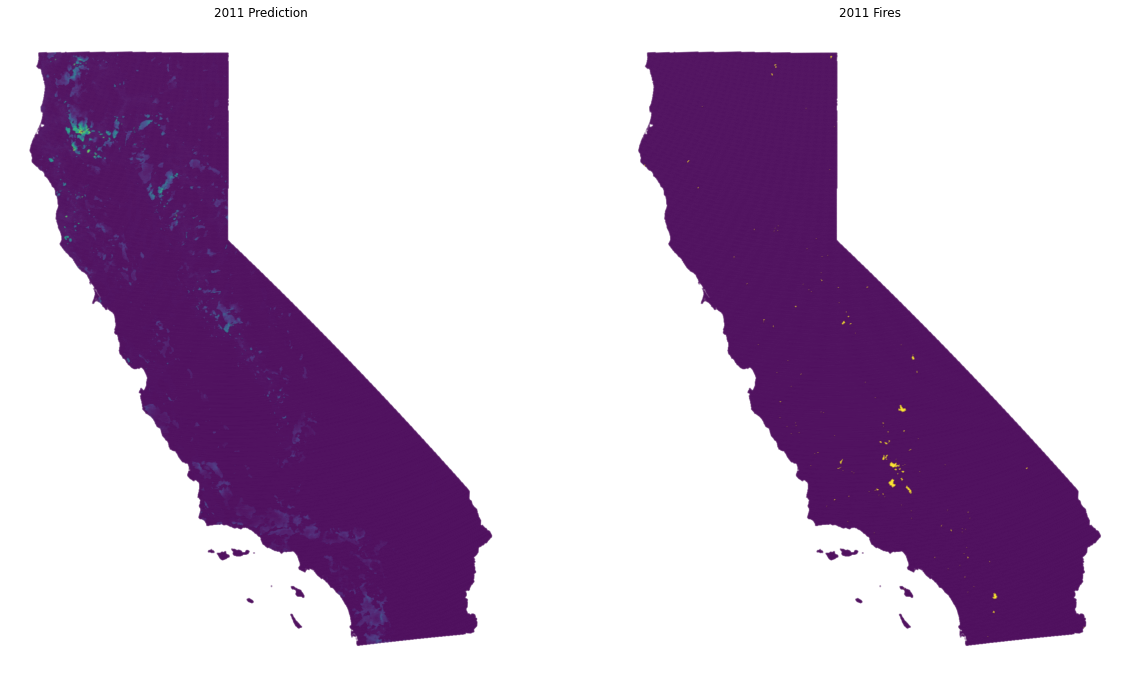

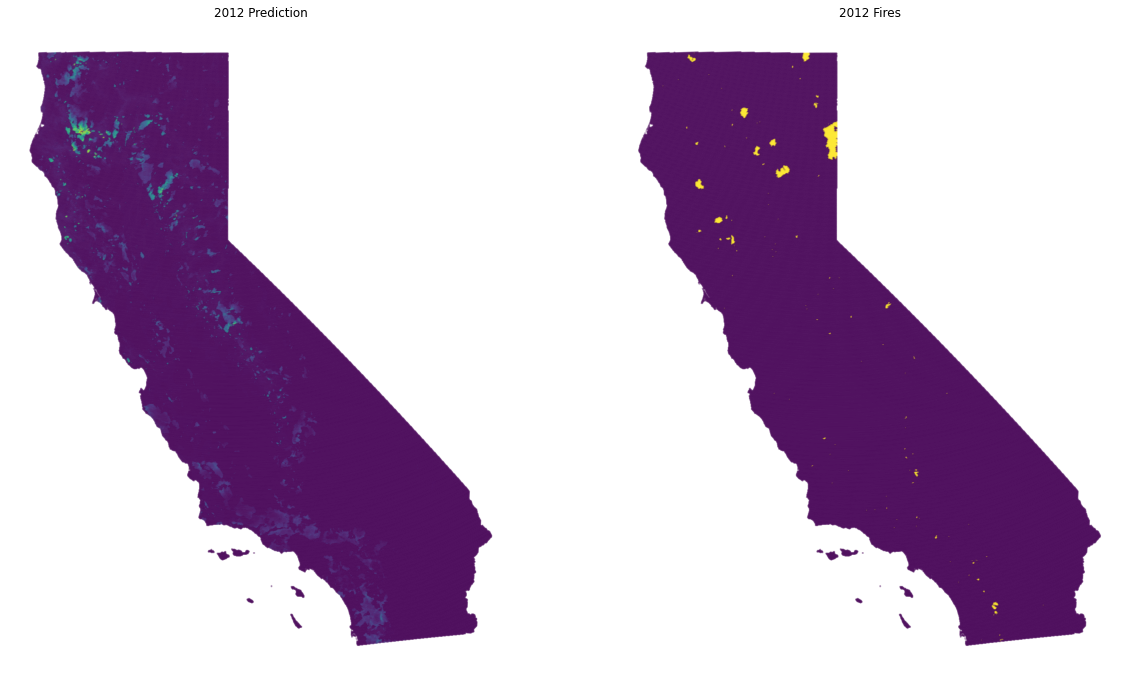

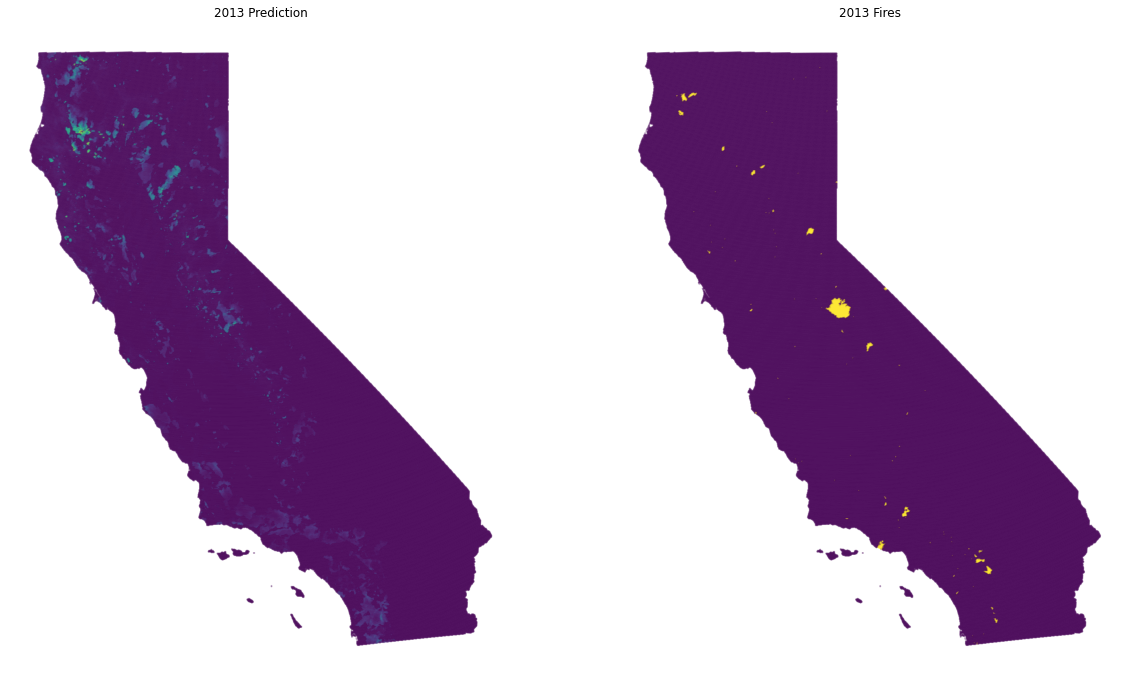

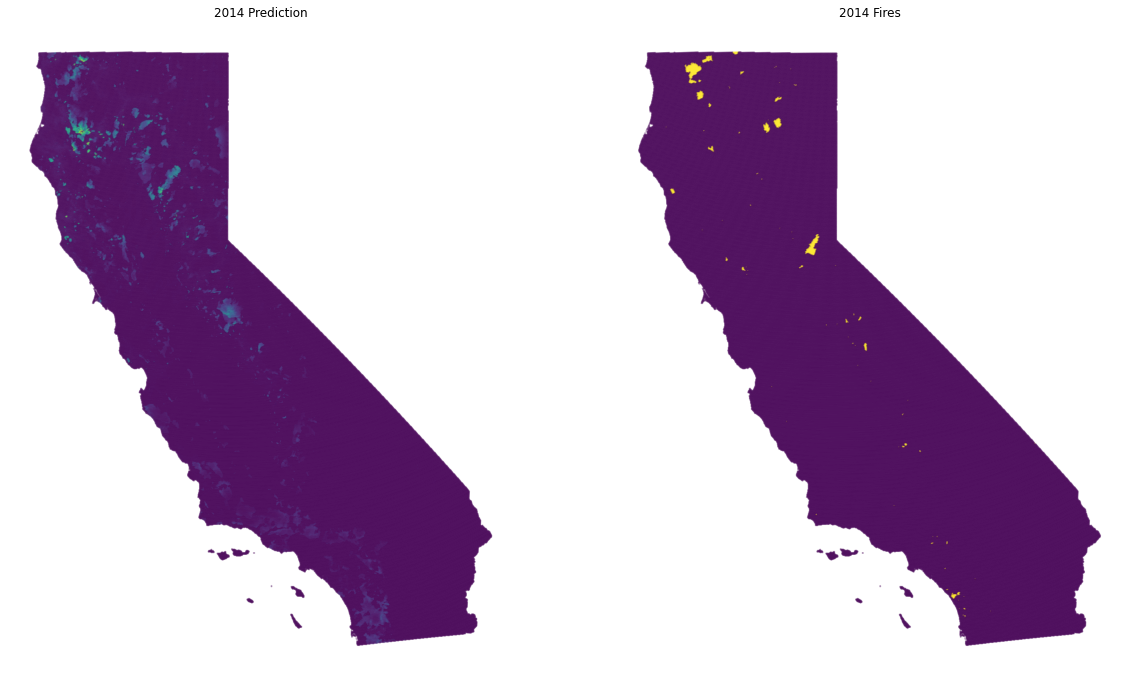

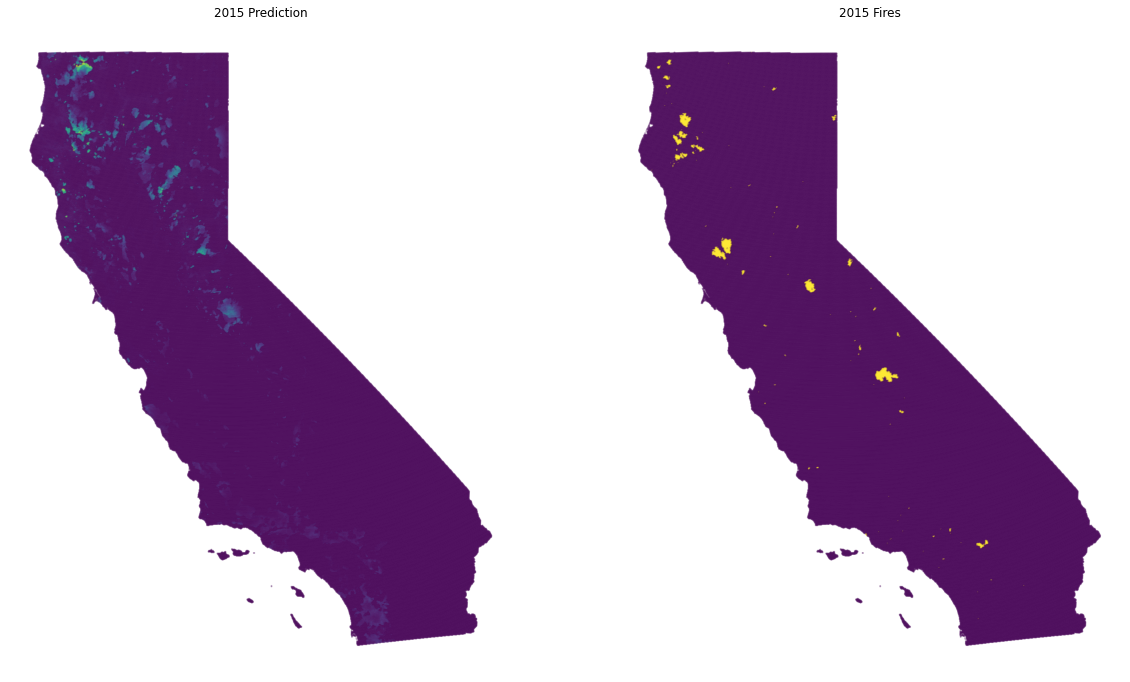

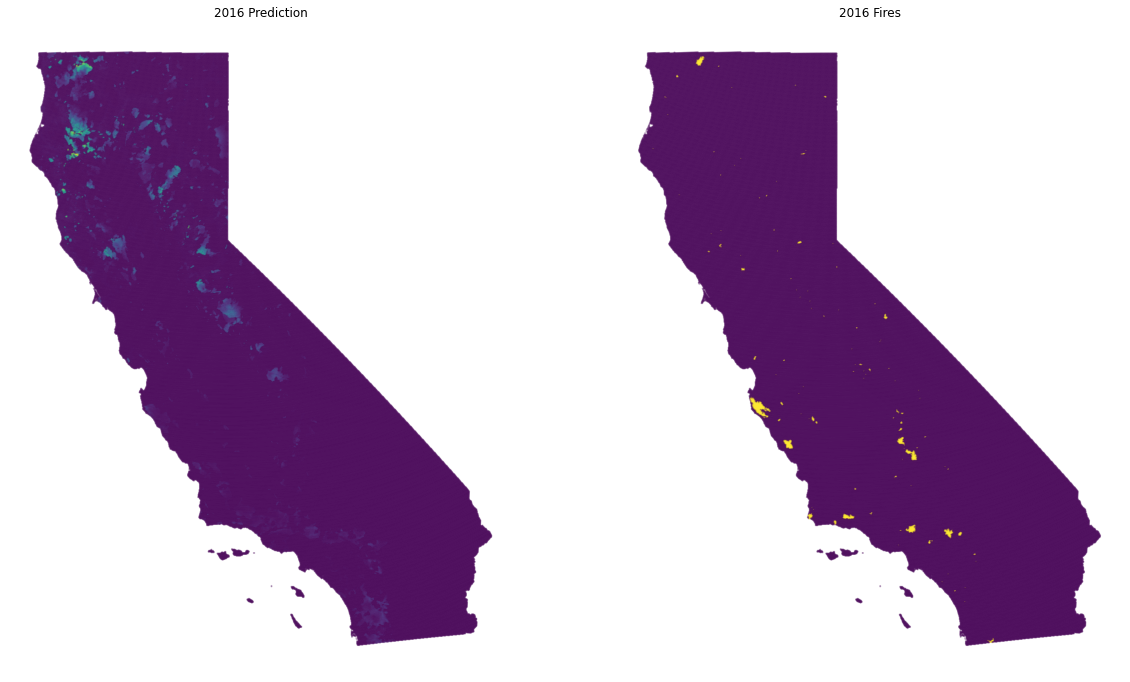

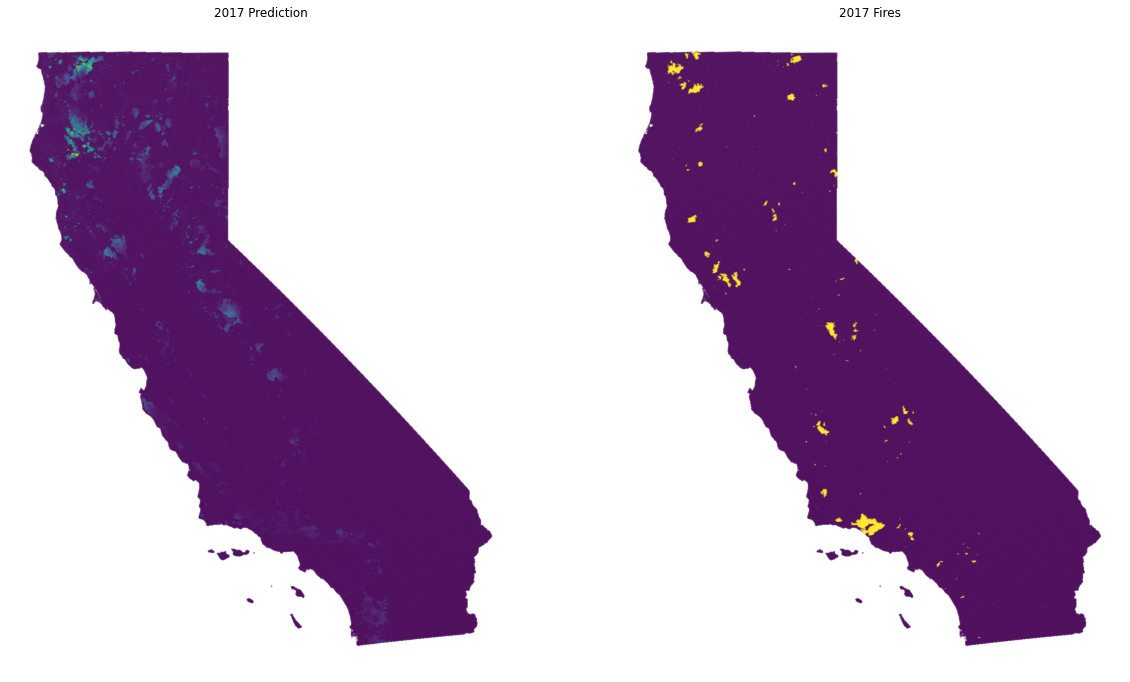

In [76]:
year = 2011
for i in range(len(predictions)):
    year = 2011 + i

    fig, axs = plt.subplots(1,2, figsize=(20,12))

    axs[0].scatter(coords['Longitude'], coords['Latitude'], alpha = 0.2, s = 1, c = predictions[i])
    axs[0].set_title(str(year) + ' Prediction')
    axs[0].axis('off')

    axs[1].scatter(coords['Longitude'], coords['Latitude'], alpha = 0.2, s = 1, c = groundTruth[i])
    axs[1].set_title(str(year) + ' Fires')
    axs[1].axis('off')

    plt.show()
